# Split in Local Development

In the first phase of the competition there is a development test which is used as first test in CodaBench. In this notebook we are going to split the training set again, generating a new development set.

Different strategies may be followed:
- Random split: Just getting, for example, 10% of the training set as development set.
- Avoid overlapping between train gold standard and development gold standard
- Avoid posts overlapping between train and development


## Monolingual Task Split

Logically, it will be done in the same way for all languages.

In [1]:
from src.datasets import TextConcatPosts, Dataset

tasks_path = "data/complete_data/tasks.json" # This is the file that will be replaced in the final version with new split
posts_path = "data/complete_data/posts.csv"
fact_checks_path = "data/complete_data/fact_checks.csv"
gs_path = "data/complete_data/pairs.csv"

posts = TextConcatPosts(posts_path, tasks_path, task_name="monolingual", gs_path=gs_path)
# fact_checks = BaseFactCheckDataset(fact_checks_path, tasks_path, task_name="monolingual")

# df_fc = fact_checks.df
df_posts_train = posts.df_train

## Duplicated Values

It would be very easy for the model to predict the fact checking label of a post if it has already seen it in the training set. Therefore, we should avoid having the same post in both the training and development sets.

This task is not completely straightforward, as we have to take into account that the same post can be written in slightly different ways. For example with different amount of spaces, emojis, caps, etc.

Possibilities:
- `text`is empty but there is `ocr`: Check duplicates in `full_text`
- `text` is not empty and duplicated but `ocr` is not: not duplicated

Duplicated = same `full_text` (OCR + text)

In [2]:
full_text_dup = df_posts_train.duplicated(subset=["full_text"], keep=False)#& (df_posts_train.full_text != "")
text_dup = df_posts_train.duplicated(subset=["text"], keep=False) & (df_posts_train.text != "")

In [3]:
print("[OCR + Text] total duplicates", df_posts_train["full_text"].duplicated().sum(), f"({df_posts_train['full_text'].duplicated().mean()})")
print("[Text] total duplicates", df_posts_train.loc[df_posts_train.text != '', 'text'].duplicated().sum(), f"({df_posts_train.loc[df_posts_train.text != '', 'text'].duplicated().mean()})")
df_posts_train[full_text_dup].sort_values("full_text").head(4)

[OCR + Text] total duplicates 27 (0.006205470006894967)
[Text] total duplicates 60 (0.01576872536136662)


,ocr,verdicts,text,lan,fb,tw,ig,full_text,gs
post_id,,,,,,,,,
4809,,False information,"A 40-ton truck lifted by 2,000 drones [URL]",eng,1,0,0,"A 40-ton truck lifted by 2,000 drones [URL]",[132558]
4810,,,"A 40-ton truck lifted by 2,000 drones [URL]",eng,0,1,0,"A 40-ton truck lifted by 2,000 drones [URL]",[132558]
6945,,False information.,Breaking News: Trump Rejects New Arms Deal wit...,eng,2,0,0,Breaking News: Trump Rejects New Arms Deal wi...,[133966]
6946,,,Breaking News: Trump Rejects New Arms Deal wit...,eng,1,0,0,Breaking News: Trump Rejects New Arms Deal wi...,[133966]


## Effective indices

In [4]:
print(df_posts_train[df_posts_train.gs.apply(len)>1][["gs"]].head(10).to_markdown())

|   post_id | gs                        |
|----------:|:--------------------------|
|       166 | [48051, 102767]           |
|       222 | [84288, 131936]           |
|       231 | [4437, 41013]             |
|       259 | [23791, 23795]            |
|       286 | [86695, 97629]            |
|       294 | [433, 1501, 47014, 47042] |
|       311 | [56129, 149207]           |
|       319 | [105482, 134630]          |
|       320 | [34240, 34246]            |
|       372 | [97170, 155277]           |


In [5]:
from sklearn.model_selection import train_test_split
# Step 1: Flatten the gs column to get all unique gs codes
all_gs = set([item for sublist in df_posts_train['gs'] for item in sublist])

# Step 2: Split these unique gs codes into train and test
gs_train, gs_test = train_test_split(list(all_gs), test_size=0.1, random_state=42)

# Step 3: Create train and test DataFrames by checking if any element in `gs` is in gs_train or gs_test
train_df = df_posts_train[df_posts_train['gs'].apply(lambda x: any(item in gs_train for item in x))]
test_df = df_posts_train[df_posts_train['gs'].apply(lambda x: any(item in gs_test for item in x))]


In [6]:
train_df.shape, test_df.shape, test_df.shape[0] / train_df.shape[0]

((3982, 9), (534, 9), 0.1341034655951783)

In [7]:
gs_list = df_posts_train.explode("gs").gs.tolist()

In [8]:
# remove from index


In [9]:
def get_split_indices(df, test_size=0.1, random_state=42, stratify_by=None):
    
    dup_criteria = df.duplicated(subset=["full_text"], keep=False)#& (df_posts_train.full_text != "")

    df_dups = df[dup_criteria].copy()
    df_not_dups = df[~dup_criteria].copy()
    # df_not_dups = df.copy()

    # idxs_dev = df_not_dups.sample(frac=test_size, random_state=random_state).index

    # idx_train = df_not_dups.index.difference(idxs_dev).union(df_dups.index)
    
    from sklearn.model_selection import train_test_split
    # idx_train, idxs_dev = train_test_split(df_not_dups.index, test_size=test_size, random_state=random_state)
    
    # Step 1: Flatten the gs column to get all unique gs codes
    all_gs = set([item for sublist in df_not_dups['gs'] for item in sublist])
    # Step 2: Split these unique gs codes into train and test
    gs_train, gs_dev = train_test_split(list(all_gs), test_size=test_size, random_state=random_state)

    gs_dups = set([item for sublist in df_dups['gs'] for item in sublist])
    gs_train = set(gs_train).union(gs_dups)
    gs_train, gs_dev = list(gs_train), list(gs_dev)
    
    
    # Step 3: Create train and test DataFrames by checking if any element in `gs` is in gs_train or gs_test
    mask_in_train = df['gs'].apply(lambda x: any(item in gs_train for item in x))
    # mask_in_dups = df_dups['gs'].apply(lambda x: any(item in gs_train for item in x))
    mask_in_dev = df['gs'].apply(lambda x: any(item in gs_dev for item in x))
    mask_in_both = mask_in_train & mask_in_dev
    
    idx_train = df[mask_in_train].index
    idx_train_exclusive = df[mask_in_train&(~mask_in_dev)].index
    idx_dev = df[mask_in_dev].index
    idx_dev_exclusive = df[mask_in_dev&(~mask_in_train)].index
    
    idx_both = df[mask_in_both]
    
    
    # idxs_dev_not_over = df_not_dups[mask_in_dev&(~mask_in_train)].index
    # idxs_dev_over = df_not_dups[mask_in_dev].index
    # idxs_dev_intersec = df_not_dups[mask_in_dev&mask_in_train].index
    
    # idx_train = idx_train.union(df_dups.index)
    
    print("Total", len(df))
    print("Train", len(idx_train))
    # print("Train (No Overlap)", len(idx_train_exclusive))
    # print("Dev", len(idx_dev))
    print("Dev (No Overlap)", len(idx_dev_exclusive))
    print("Sum", len(idx_train) + len(idx_dev_exclusive))

    # print("Dev (Intersection)", len(idx_both))

    assert len(df) == len(idx_train) + len(idx_dev_exclusive)

    return idx_train.tolist(), idx_dev_exclusive.tolist()

In [10]:
idx_train, idxs_dev = get_split_indices(df_posts_train, test_size=0.1, random_state=42)

Total 4351
Train 4012
Dev (No Overlap) 339
Sum 4351


In [11]:
len(df_posts_train)

4351

In [12]:
len(idx_train), len(idxs_dev)

(4012, 339)

In [13]:
posts.df_dev.shape[0] / df_posts_train.shape[0]

0.10985980234428867

In [14]:
len(idx_train), len(idxs_dev), len(idx_train) + len(idxs_dev), len(df_posts_train), len(idxs_dev) / len(idx_train)

(4012, 339, 4351, 4351, 0.08449651046859422)

# Cross-lingual Task Split

In this case, it could happen that there is literally the same post in two different languages. In this case, we should avoid having the same post in both the training and development sets. For that, some scores of parallelism between the posts in different languages could be calculated.

Also, and more important, it is possible that there is more imbalance in the training set for some languages than for others. In this case, we should take into account the language when splitting the training set, stratifying by language.

In [15]:
posts_xl = TextConcatPosts(posts_path, tasks_path, task_name="crosslingual", gs_path=gs_path)
# fact_checks = BaseFactCheckDataset(fact_checks_path, tasks_path, task_name="monolingual")

# df_fc = fact_checks.df
df_posts_train_xl = posts_xl.df_train

In [16]:
df_posts_train_xl.sample(5)

,ocr,verdicts,text,lan,fb,tw,ig,full_text,gs
post_id,,,,,,,,,
9120,,False information,"Eeeeh seigneur, piégé jusqu’au coup par la Fra...",fra,1,0,0,"Eeeeh seigneur, piégé jusqu’au coup par la Fr...",[36713]
6765,Menü Bild Ukraine-Krise FEURIGER HASS ZERSTÖRT...,False information,"Bild: Refugiados ucranianos en Alemania, mient...",spa,1,0,0,Menü Bild Ukraine-Krise FEURIGER HASS ZERSTÖRT...,"[95194, 112947, 112948, 112951, 137252]"
23112,,False information,بعد حرق واتلاف القران الكريم ومنع المسلمين من ...,ara,1,0,0,بعد حرق واتلاف القران الكريم ومنع المسلمين من...,[167738]
11570,Rodrigo Constantino [USER] . 1 h Entenderam po...,Partly false information,"Há 30 anos, a previsão dos ""cientistas da ONU""...",por,1,0,0,Rodrigo Constantino [USER] . 1 h Entenderam po...,[23547]
23119,AANGA NARRRRRRRRRRRRRRR AANANENANE NA NION VAN...,False information,بلاغ لمحافظ الإسكندرية ولوزير الثقافة ولوزير ا...,ara,1,0,0,AANGA NARRRRRRRRRRRRRRR AANANENANE NA NION VAN...,[165760]


In [17]:
idx_train_xl, idxs_dev_xl = get_split_indices(df_posts_train_xl, test_size=0.1, random_state=42, stratify_by="lan")

Total 4972
Train 4587
Dev (No Overlap) 385
Sum 4972


<Axes: >

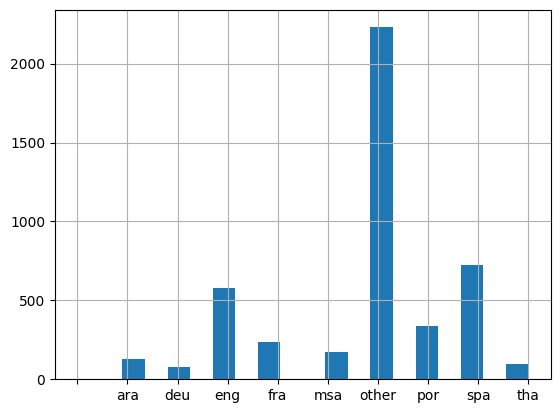

In [18]:
df_posts_train_xl.loc[idx_train_xl, "lan"].sort_values().hist(bins=20)

<Axes: >

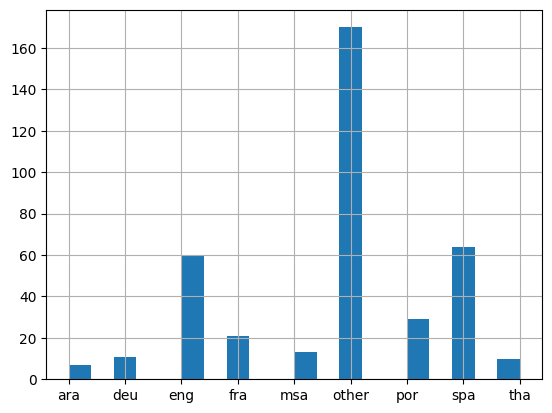

In [19]:
df_posts_train_xl.loc[idxs_dev_xl, "lan"].sort_values().hist(bins=20)

# Index Creation

In [20]:
from tqdm import tqdm
new_tasks_mono = posts.tasks["monolingual"].copy()

for lan in tqdm(new_tasks_mono.keys()):
    posts = TextConcatPosts(posts_path, tasks_path, task_name="monolingual", gs_path=gs_path, lang=lan)
    df_posts_train = posts.df_train

    idx_train, idxs_dev = get_split_indices(df_posts_train, test_size=0.1, random_state=42)
    
    new_tasks_mono[lan]["posts_train"] = idx_train
    new_tasks_mono[lan]["posts_dev"] = idxs_dev

 12%|█▎        | 1/8 [00:01<00:12,  1.79s/it]

Total 1596
Train 1443
Dev (No Overlap) 153
Sum 1596


 25%|██▌       | 2/8 [00:03<00:11,  1.86s/it]

Total 5628
Train 5122
Dev (No Overlap) 506
Sum 5628


 38%|███▊      | 3/8 [00:05<00:09,  1.86s/it]

Total 4351
Train 4012
Dev (No Overlap) 339
Sum 4351


 50%|█████     | 4/8 [00:07<00:07,  1.87s/it]

Total 2571
Train 2405
Dev (No Overlap) 166
Sum 2571


 62%|██████▎   | 5/8 [00:09<00:05,  1.85s/it]

Total 465
Train 418
Dev (No Overlap) 47
Sum 465


 75%|███████▌  | 6/8 [00:11<00:03,  1.87s/it]

Total 667
Train 606
Dev (No Overlap) 61
Sum 667


 88%|████████▊ | 7/8 [00:12<00:01,  1.85s/it]

Total 1062
Train 964
Dev (No Overlap) 98
Sum 1062


100%|██████████| 8/8 [00:14<00:00,  1.85s/it]

Total 676
Train 611
Dev (No Overlap) 65
Sum 676


In [21]:
posts_xl = TextConcatPosts(posts_path, tasks_path, task_name="crosslingual", gs_path=gs_path)
df_posts_train_xl = posts_xl.df_train

new_tasks_xl = posts.tasks["crosslingual"].copy()

posts = TextConcatPosts(posts_path, tasks_path, task_name="crosslingual", gs_path=gs_path)
df_posts_train = posts.df_train

idx_train, idxs_dev = get_split_indices(df_posts_train, test_size=0.1, random_state=42)

new_tasks_xl["posts_train"] = idx_train
new_tasks_xl["posts_dev"] = idxs_dev

Total 4972
Train 4587
Dev (No Overlap) 385
Sum 4972


In [22]:
new_tasks = posts.tasks.copy()
new_tasks["monolingual"] = new_tasks_mono
new_tasks["crosslingual"] = new_tasks_xl

In [23]:
import pandas as pd
d_stats = {}
for lan in new_tasks["monolingual"].keys():
    d_stats[lan] = {
        "train": len(new_tasks["monolingual"][lan]["posts_train"]),
        "dev": len(new_tasks["monolingual"][lan]["posts_dev"]),
        "ratio": len(new_tasks["monolingual"][lan]["posts_dev"]) / len(new_tasks["monolingual"][lan]["posts_train"])
    }

d_stats["crosslingual"] = {
                            "train": len(new_tasks["crosslingual"]["posts_train"]),
                            "dev": len(new_tasks["crosslingual"]["posts_dev"]),
                            "ratio": len(new_tasks["crosslingual"]["posts_dev"]) / len(new_tasks["crosslingual"]["posts_train"])
                    }

df_stats = pd.DataFrame(d_stats).T
df_stats.to_csv("data/splits/stats/tasks_no_gs_overlap.csv", index=True)

In [24]:
for lan in posts.tasks["monolingual"].keys():
    print(lan, len(posts.tasks["monolingual"][lan]["posts_train"]), len(posts.tasks["monolingual"][lan]["posts_dev"]), len(posts.tasks["monolingual"][lan]["posts_dev"]) / len(posts.tasks["monolingual"][lan]["posts_train"]))
    
print("cross", len(posts.tasks["crosslingual"]["posts_train"]), len(posts.tasks["crosslingual"]["posts_dev"]))

fra 1596 188 0.11779448621553884
spa 5628 615 0.10927505330490406
eng 4351 478 0.10985980234428867
por 2571 302 0.11746402178140801
tha 465 42 0.09032258064516129
deu 667 83 0.12443778110944528
msa 1062 105 0.09887005649717515
ara 676 78 0.11538461538461539
cross 4972 552


In [25]:
import json
tasks_path = "data/splits/tasks_no_gs_overlap.json"

with open(tasks_path, "w") as f:
    json.dump(new_tasks, f, indent=4)

# Check it is working

In [26]:
from src.datasets import TextConcatPosts, Dataset

tasks_path = "data/splits/tasks_no_gs_overlap.json" # This is the file that will be replaced in the final version with new split
posts_path = "data/complete_data/posts.csv"
fact_checks_path = "data/complete_data/fact_checks.csv"
gs_path = "data/complete_data/pairs.csv"

posts = TextConcatPosts(posts_path, tasks_path, task_name="crosslingual", gs_path=gs_path)
df_posts_train = posts.df_train
df_posts_dev = posts.df_dev

In [27]:
df_posts_train.head()

,ocr,verdicts,text,lan,fb,tw,ig,full_text,gs
post_id,,,,,,,,,
3,"""Australia 50 MILLONES de dosis de ""vacuna"" re...",False,,fra,0,0,1,"""Australia 50 MILLONES de dosis de ""vacuna"" re...",[50973]
16,"""Estrictamente y hablando con sentido, la conq...",Partly false information,,spa,1,0,0,"""Estrictamente y hablando con sentido, la conq...",[38000]
60,#Artés Presidente #Save Palestine ... [USER] M...,Partly false information,,spa,1,0,0,#Artés Presidente #Save Palestine ... [USER] M...,[50802]
62,#CNN: Child soldiers are ok if they are to def...,Altered photo,,eng,1,0,0,#CNN: Child soldiers are ok if they are to def...,"[34139, 134205]"
71,#قانون_ساز_طوائف ملکہ پکھراج کی نواسی معروف رق...,False information,,other,1,0,0,#قانون_ساز_طوائف ملکہ پکھراج کی نواسی معروف رق...,[13904]


In [28]:
posts.langs

['fra', 'spa', 'eng', 'por', 'tha', 'deu', 'msa', 'ara']

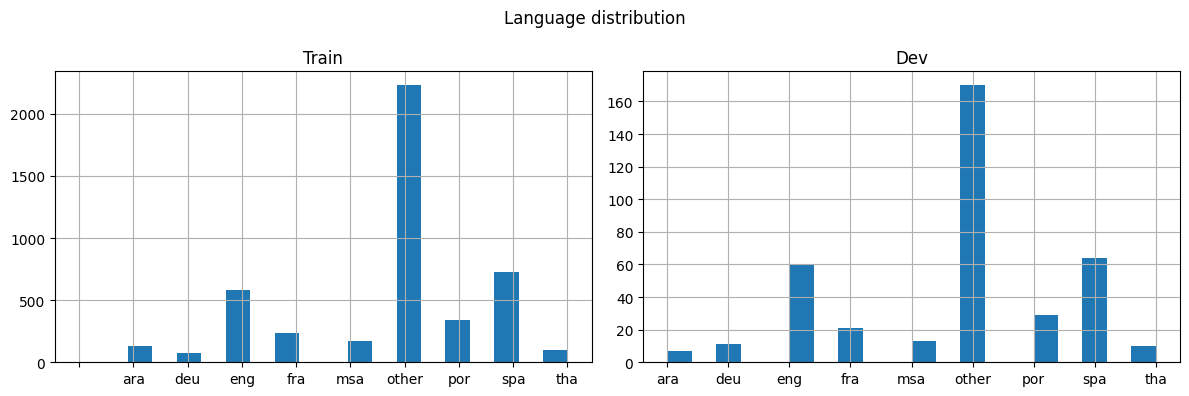

In [29]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

df_posts_train["lan"].sort_values().hist(bins=20, ax=ax[0])
df_posts_dev["lan"].sort_values().hist(bins=20, ax=ax[1])

ax[0].set_title("Train")
ax[1].set_title("Dev")

fig.suptitle("Language distribution")
fig.tight_layout()


In [30]:

ds = Dataset(posts_path, tasks_path, task_name="crosslingual")
ds.df.head()

,post_id,instances,ocr,verdicts,text
0,0,"[(1608571882.0, fb)]",[(! Dreister Impf-Fake von Markus Söder! Es is...,['False information'],
1,1,"[(1586139153.0, fb)]",[(!! WARNING !! A new thing circulating now. P...,['False information'],
2,2,"[(1610052141.0, fb), (1610072448.0, fb)]","[(""Actually, he's a damn sight better than any...",['Missing context'],
3,3,"[(1645187790.0, ig)]","[(""Australia 50 MILLONES de dosis de ""vacuna"" ...",['False'],
4,4,"[(1581697500.0, fb)]","[(""Bienaventurados los perseguidos por mi caus...",[],


In [31]:
ds.df["ocr"].apply(lambda x: x[0][-1][0][0] if (isinstance(x, list)&len(x)>0) else "")

0        deu
1        eng
2        eng
3        fra
4        spa
        ... 
24426       
24427    eng
24428       
24429    eng
24430    kor
Name: ocr, Length: 24431, dtype: object

In [32]:
train_gs = posts.df_train.explode("gs")["gs"].unique()
dev_gs = posts.df_dev.explode("gs")["gs"].unique()

print(len(set(train_gs) & set(dev_gs)), len(set(train_gs)), len(set(dev_gs)))
print(posts.df_train.index.intersection(posts.df_dev.index))

0 3996 310
Index([], dtype='int64', name='post_id')


In [33]:
for lan in posts.langs:
    print(lan)
    posts = TextConcatPosts(posts_path, tasks_path, task_name="monolingual", gs_path=gs_path, lang=lan)
    train_gs = posts.df_train.explode("gs")["gs"].unique()
    dev_gs = posts.df_dev.explode("gs")["gs"].unique()

    print(set(train_gs) & set(dev_gs))
    print(posts.df_train.index.intersection(posts.df_dev.index))
    # assert len(set(train_gs) & set(dev_gs)) == 0
    # assert len(posts.df_train.index.intersection(posts.df_dev.index)) == 0

fra


set()
Index([], dtype='int64', name='post_id')
spa
set()
Index([], dtype='int64', name='post_id')
eng
set()
Index([], dtype='int64', name='post_id')
por
set()
Index([], dtype='int64', name='post_id')
tha
set()
Index([], dtype='int64', name='post_id')
deu
set()
Index([], dtype='int64', name='post_id')
msa
set()
Index([], dtype='int64', name='post_id')
ara
set()
Index([], dtype='int64', name='post_id')
